In [44]:
%load_ext autoreload
%autoreload 2
from Environment import Environment
from LoadBalancer import LoadBalancer
from Source import Source, ArrivalSchedule

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Running simple simulation
- 10 servers fixed
- arrivalProb 0.5 fixed
- two arrival types
- time limit 10

In [63]:
stopTime = 10*60*60
env = Environment(stopTime=stopTime)
loadBalancer = LoadBalancer(nServers=3, environment=env)
requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalProb = 0.7
samplingInterval = 0.05
source = Source(samplingInterval, arrivalProb, requestTypes, loadBalancer, env)
env.run(debug=False)

## Checking results

Benefit of running the system: -174528.99999998763


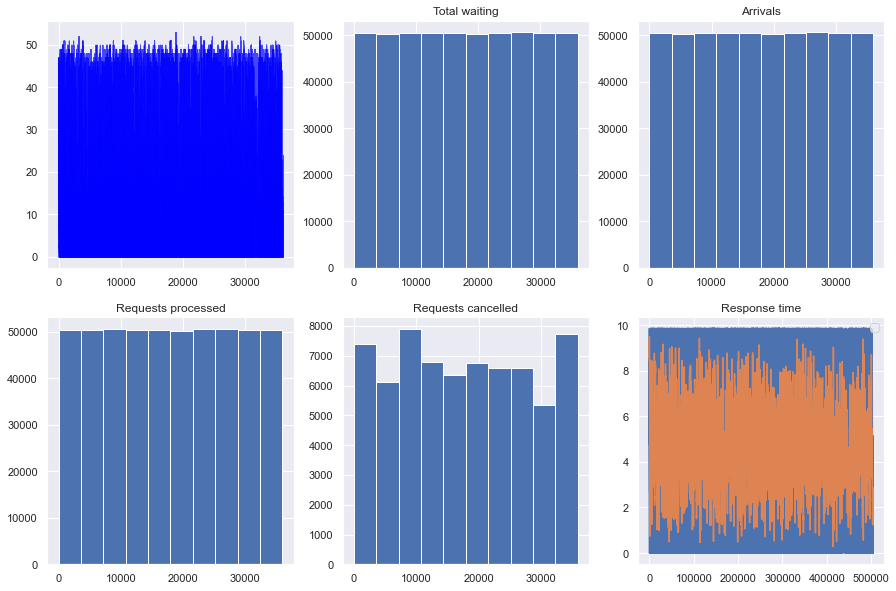

In [65]:
def plotSimulationSummary(environment: Environment, nServers=3):
    processCost = 1
    cancelCost = -10
    serverCost = -100

    nCancelled = len(environment.log['requestCancelled']) if 'requestCancelled' in environment.log.keys() else 0
    cost = len(environment.log['requestProcessed']) *processCost + nCancelled * cancelCost + nServers*env.currentTime/60/60*serverCost
    print(f"Benefit of running the system: {cost}")
    queueSizeKeys = [key for key in environment.log.keys() if 'queueSize' in key]

    fig, axs = plt.subplots(2,3, figsize=(15,10))
    axs_flat = axs.flatten()

    for key in queueSizeKeys:
         axs_flat[0].fill_between(environment.logTime[key], environment.log[key], alpha=0.7, color='blue')
        
    plt.legend(labels=[key.strip("queueSize_") for key in queueSizeKeys])

    axs_flat[1].hist(environment.logTime["requestStartWaiting"])
    axs_flat[1].set_title("Total waiting")

    axs_flat[2].hist(environment.logTime["arrivalEvent"])
    axs_flat[2].set_title("Arrivals")

    axs_flat[3].hist(environment.logTime["requestProcessed"])
    axs_flat[3].set_title("Requests processed")

    if 'requestCancelled' in environment.log.keys():
        axs_flat[4].hist(environment.logTime["requestCancelled"])
        axs_flat[4].set_title("Requests cancelled")

    axs_flat[5].plot(environment.log["requestWaitingTime"])
    rolling = pd.Series(index=environment.logTime["requestWaitingTime"], data=environment.log["requestWaitingTime"]).rolling(100).mean()
    axs_flat[5].plot(rolling.values)
    axs_flat[5].set_title("Response time")

plotSimulationSummary(environment=env)


## Time varying arrivals

In [52]:
stopTime = 12*60*60
samplingInterval = 0.05
env = Environment(stopTime=stopTime)
loadBalancer = LoadBalancer(nServers=3, environment=env)
requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalProb = 0.7
source = Source(samplingInterval, arrivalProb, requestTypes, loadBalancer, env)
schedule = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.9,0.8,0.7,0.8,0.7,0.6] #12 periods
arrivalSchedule = ArrivalSchedule(0.5*60*60,arrivalSchedule=schedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

Benefit of running the system: -276674.0


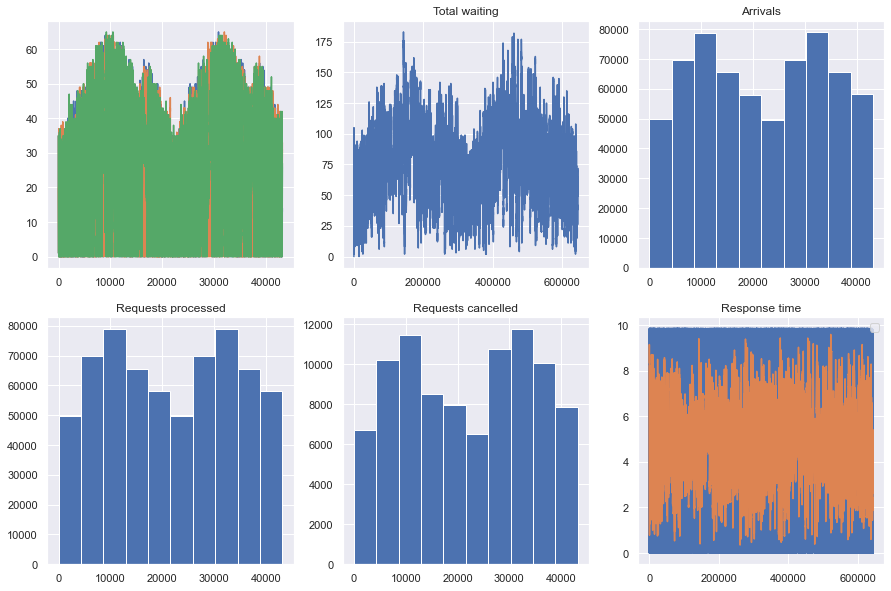

In [53]:
plotSimulationSummary(environment=env)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


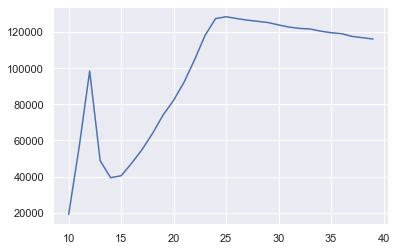

In [31]:
stopTime = 3*60*60
samplingInterval = 0.05
profit = []
requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
processCost = 1
cancelCost = -10
serverCost = -300
nServers = range(10,40)
for n in nServers:
    env = Environment(stopTime=stopTime)
    loadBalancer = LoadBalancer(nServers=n, environment=env)
    arrivalProb = 0.7
    source = Source(samplingInterval, arrivalProb, requestTypes, loadBalancer, env)
    source.scheduleNextSampleEvent()
    env.run(debug=False)
    nCancelled = len(env.log['requestCancelled']) if 'requestCancelled' in env.log.keys() else 0
    cost = len(env.log['requestProcessed']) * processCost + nCancelled * cancelCost + stopTime/60/60*n*serverCost
    profit.append(cost)


plt.plot(nServers, profit)